In [1]:
#for interactive 3d plot 
!pip install PrettyTable > /dev/null 2>&1
from prettytable import PrettyTable
import sys

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
import enum

# import ipyvolume as ipv
%matplotlib inline


In [2]:
# Files
trainFile = 'trainNN.txt'
testFile = 'testNN.txt'

For softmax loss
$$dZ = \frac{dL}{dZ} = A - Y$$
\begin{align}
    dW = \frac{dL}{dW^L} &= \frac{dL}{dZ^L} \frac{dZ^L}{dW^L} \\ 
    &= (A^L−Y)\frac{d}{dW^L}(A^{L−1}W^L+b^L) \\
    &=(A^L - Y) A^{L-1} \\
    db = \frac{dL}{db} &= \frac{dL}{dZ^L} \frac{dZ^L}{db} \\ 
    &= (A^L−Y)\frac{d}{db}(A^{L−1}W^L+b^L) \\
    &=(A^L - Y) \\
    dA^{L-1} = \frac{dL}{dA^{L-1}} &= \frac{dL}{dZ^L} \frac{dZ^L}{dA^{L-1}} \\ 
    &= (A^L−Y)\frac{d}{dA^{L-1}}(A^{L−1}W^L+b^L) \\
    &=(A^L - Y) W^L \\
    \text{In general }dA^{i-1} = \frac{dL}{dA^{i-1}} &= \frac{dL}{dZ^i} \frac{dZ^i}{dA^{i-1}} \\ 
    &= dZ^i W^i \\
\end{align}

For all other layers except the layer L we can define as:
\begin{align}
    dW = \frac{dL}{dW^{L-1}}  &= \frac{dL}{dZ^L}\frac{dZ^L}{dA^{L−1}} \frac{dA^{L−1}}{dZ^{L−1}}\frac{dZ^{L−1}}{dW^{L−1}} \\ 
    &=  (A^L−Y)\frac{d}{dA^{L-1}}(A^{L−1}W^{L}+b^{L}) 
    \frac{d}{dZ^{L−1}} (σ(Z^{L−1})) \frac{d}{dW^{L−1}}(A^{L−2}W^{L−1}+b^{L−1})\\
    &= (A^L - Y) W^L \sigma'(Z^{L−1})A^{L−2}\\ 
    \text{In general } dW^{i} = dZ^{i} A^{i-1} \\
     dZ^{i} = dA^{i}  \sigma'(Z^{i})\\
\end{align}





In [3]:
    
def getBinarization(Y, num_class):
    """
        Return num_class X sample matrix of 0,1s 
    """
    from sklearn.preprocessing import LabelEncoder 
    from sklearn.preprocessing import OneHotEncoder 
    enc = OneHotEncoder() 
    df = np.array(Y)

    enc.fit(pd.DataFrame(df.reshape(len(df),)))
    matrix = enc.transform(pd.DataFrame(df.reshape(len(df),))).toarray().T
    return matrix, enc.categories_[0]




def pre_process_data(train_x, train_y, test_x, test_y):
    #normalization 
    for i in range(numFeature):
        train_x[:, i] = (train_x[:, i] - np.mean(train_x[:,i]))/np.std(train_x[:,i])
        test_x[:, i] = (test_x[:, i] - np.mean(test_x[:,i]))/np.std(test_x[:,i])
    
    print(train_x)
    from sklearn.preprocessing import LabelEncoder 
    from sklearn.preprocessing import OneHotEncoder 
    enc = OneHotEncoder(sparse=False, categories='auto')
    train_y = enc.fit_transform(train_y.reshape(len(train_y), -1))
 
    test_y = enc.transform(test_y.reshape(len(test_y), -1))
 
    return train_x, train_y, test_x, test_y

In [4]:
from abc import ABC, abstractmethod 

class Activation(ABC): 

    @abstractmethod
    def __call__(self, Z):
        pass
    
    @abstractmethod
    def _derivative(self, Z):
        pass
    
    @abstractmethod
    def backward(self, dA):
        pass
    
    @abstractmethod
    def __repr__(self):
        pass

In [5]:
class Linear:
    def __init__(self, row, col):
        np.random.seed(1)
        self.W = np.random.randn(row, col)
        self.b = np.zeros((row, 1))
        self.A_prev = None
        
    def update(self,  dW, db, m, learning_rate = 0.9 ,  l2_reg_param = 0.1):
        self.W = self.W - learning_rate * dW  - learning_rate * l2_reg_param / m * self.W
        self.b = self.b - learning_rate * db
    
    def __repr__(self):
        return str(self.W)
    
    def __call__(self, A):
        self.A_prev = A
        Z = self.W.dot(A) + self.b
        assert(Z.shape == (self.W.shape[0], A.shape[1]))

        return Z

    def backward(self, m,  dZ=None):        

        dW = dZ.dot(self.A_prev.T) / m 
        db = np.sum(dZ, axis=1, keepdims=True) / m

        dA_prev = (self.W.T).dot(dZ)
        assert (dA_prev.shape == self.A_prev.shape)
        assert (dW.shape == self.W.shape)

        return dA_prev, dW, db

    
class Sigmoid(Activation):
    def __init__(self):
        self.A = None
    
    def __call__(self, Z):
        self.Z = Z
        return 1/(1 + np.exp(-Z)) 
    
    def _derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return s * (1 - s)

    def backward(self, dA):
        dZ = dA * self._derivative(self.Z)
        return dZ
    
    def __repr__(self):
        return str(self.Z)

        
class LeakyRelu(Activation):
    SLOPE = 0.1
    def __init__(self):
        self.A = None
        self.slope = 0.1
    
    def __call__(self, Z):
        self.Z = Z
        return Z*(Z>0) + LeakyRelu.SLOPE*Z*(Z<0)
    
    def _derivative(self, Z):
        return (1.0)*(Z>0)+(LeakyRelu.SLOPE)*(Z<0)

    def backward(self, dAPrev):
        dZ = dAPrev * self._derivative(self.Z)
        return dZ
    
    def __repr__(self):
        return str(self.Z)
    
    
class Softmax:
    def __init__(self):
        self.A = None
    
    def __call__(self, x):
        expZ = np.exp(x)
        self.A =  expZ / expZ.sum(axis=0, keepdims=True) # activation 
        return self.A

    def backward(self, Y):
        dZ = self.A - Y
        return dZ
    
    def __repr__(self):
        return str(self.A[:,:3])



In [6]:
class ACTIVATION_ENUM(str, enum.Enum): 
    SIGMOID = "sigmoid"
    LEAKY_RELU = "leaky_relu"
    
def get_activation(activation):
    if activation == ACTIVATION_ENUM.SIGMOID:
        return Sigmoid()
    elif activation == ACTIVATION_ENUM.LEAKY_RELU:
        return LeakyRelu()


In [7]:
class ANN:
    
    def __init__(self, layers_size, num_features, num_class, 
                 hidden_layer_activation, l2_regularization_param=0.1):
        self.layers_size = layers_size
        self.layers_size.append(num_class) # output layer 
        self.layers_size.insert(0, num_features) # input layer 
        self.l2_regularization_param = l2_regularization_param 
        
        self.n = 0
        self.costs = []
        
        self.num_features = num_features
        self.num_class = num_class
        self.num_layers = len(self.layers_size) - 1   # excluding input layers
        
        self.linear_layer = []
        self.activation_layer = []        
        
        # Linear-Sigmoid -> Linear-Sigmoid ( for L-1 layers )
        
        #L linear layers 
        for i in range(1, self.num_layers+1):  
            self.linear_layer.append( Linear(self.layers_size[i], self.layers_size[i-1]) )  
        
        for i in range(self.num_layers-1):
            self.activation_layer.append( get_activation(hidden_layer_activation))  # For L-1 activation layer 
        
        self.softmax = Softmax() # L-th layer 
        
    
    def get_cost(self, Y, A):
        L2_regularization_cost = 0 
        for l in range(self.num_layers):
            L2_regularization_cost += np.sum(np.square(self.linear_layer[l].W))
            
        L2_regularization_cost *=  self.l2_regularization_param/(2* self.n)
        
        return -np.mean(Y * np.log(A.T+ 1e-8)) +  L2_regularization_cost
    
    
    def forward(self, X):
        A = np.copy(X).T
        assert(A.shape[0] == self.num_features)
        
        for l in range(self.num_layers - 1):
            Z = self.linear_layer[l](A) 
            A = self.activation_layer[l](Z)

        Z = self.linear_layer[-1](A)  
        A = self.softmax(Z)
        return A
    
    
 
    def fit(self, X, Y, learning_rate=0.01, n_iterations=2500):
        
        np.random.seed(1)
        self.n = X.shape[0]
        for loop in range(n_iterations):
            A = self.forward(X)
            cost = self.get_cost( Y, A )
            dZ = self.softmax.backward(Y.T)

        
            dAPrev, dW, db = self.linear_layer[-1].backward(self.n, dZ)
            self.linear_layer[-1].update(dW, db, self.n,  learning_rate, self.l2_regularization_param )

            for l in range(self.num_layers - 1, 0, -1):
                dZ = self.activation_layer[l-1].backward(dAPrev)
                dAPrev, dW, db = self.linear_layer[l-1].backward(self.n, dZ)
                
                self.linear_layer[l-1].update(dW, db, self.n,  learning_rate, self.l2_regularization_param )


            if loop % 100 == 0:
                print("Cost: ", cost, "Train Accuracy:", self.predict(X, Y))
 
            if loop % 10 == 0:
                self.costs.append(cost)
 
    def predict(self, X, Y, filePrint=False):

        A = self.forward(X)
        y_hat = np.argmax(A, axis=0)
        Y = np.argmax(Y, axis=1)
        accuracy = (y_hat == Y).mean()
        
        if filePrint:
            original_stdout = sys.stdout # Save a reference to the original standard output

            with open('1505014_report.txt', 'w') as f:
                sys.stdout = f # Change the standard output to the file we created.
                print('Number of hidden layers ', self.num_layers - 1 )
                print('List of mis-classified samples')
                t = PrettyTable(['sample no.', 'feature values', 'actual class', 'predicted class'])

                for i in range(len(Y)):
                    y_pred = y_hat[i]
                    if y_pred != Y[i]:
                        t.add_row([i, x_test[i,:],  y_test[i], y_pred])
                print(t)
                print('Accurary for Neural Network ')
                print(accuracy*100, '%')
                sys.stdout = original_stdout # Reset the standard output to its original value

        return accuracy * 100
 
    def plot_cost(self):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.show()


In [8]:

missing_values = ["n/a", "na", "--","NA","N/A","?"]

    
df = pd.read_csv( trainFile, na_values = missing_values, delimiter=r'\s+', header=None)


train_x, train_y = np.array(df.iloc[:,:-1].values.tolist()), np.array(df.iloc[:,-1].values.tolist() )
numFeature, numClass = df.shape[1]-1, len(set(train_y))

dfTest = pd.read_csv( testFile, na_values = missing_values, delimiter=r'\s+', header=None)
test_x, test_y = np.array(dfTest.iloc[ :,:-1].values.tolist()), np.array(dfTest.iloc[:,-1].values.tolist() )

train_x1, train_y1, test_x1, test_y1 = pre_process_data(train_x, train_y, test_x, test_y)
    

[[-1.23550865 -1.38630451 -1.33573181 -1.3946362 ]
 [-0.46809072 -0.48626348 -0.47001247 -0.4894833 ]
 [ 1.22327934  1.30075385  1.32246657  1.30438191]
 ...
 [-1.38168187 -1.37596632 -1.35725188 -1.40248016]
 [-0.58225414 -0.46142325 -0.50124281 -0.48931872]
 [ 1.33308563  1.31153135  1.31478377  1.34229115]]


train_x's shape: (500, 4)
test_x's shape: (500, 4)
Cost:  0.35909778599374265 Train Accuracy: 49.8
Cost:  0.03737680307684004 Train Accuracy: 100.0
Cost:  0.024603243422458523 Train Accuracy: 100.0
Cost:  0.02097661320480911 Train Accuracy: 100.0
Cost:  0.019578391508890194 Train Accuracy: 100.0
Train Accuracy: 100.0
Test Accuracy: 100.0


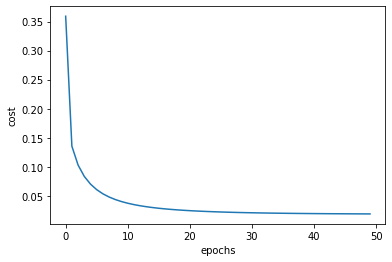

In [9]:

print("train_x's shape: " + str(train_x1.shape))
print("test_x's shape: " + str(test_x1.shape))

layers_dims = [] # excluding input, output layer 

ann = ANN(layers_dims, numFeature, numClass, ACTIVATION_ENUM.LEAKY_RELU , l2_regularization_param = 0.1 ) #pass l2_param = 0 if no regularization needed 
ann.fit(train_x1, train_y1, learning_rate=0.9, n_iterations=500)
print("Train Accuracy:", ann.predict(train_x1, train_y1))
print("Test Accuracy:", ann.predict(test_x1, test_y1, filePrint=True))
ann.plot_cost()